In [1]:
%matplotlib inline
import ipfix, qof, imp
import template, graph
from loader import load_df
import pandas as pd

# init IE specs
ipfix.ie.use_iana_default()
ipfix.ie.use_5103_default()
ipfix.ie.use_specfile("qof.iespec")
ipfix.ie.use_specfile("copycat.iespec")
ipfix.types.use_integer_ipv4()

# init campaign variables
output_dir  = "plots/"
all_cids1 = ["sch1-0002-t3-f1-1", "sch1-0002-t3-f1-2", "sch1-0002-t3-f1-3"]
all_cids2 = ["sch1-0002-t3-f2-1", "sch1-0002-t3-f2-2", "sch1-0002-t3-f2-3"]
all_cids3 = ["sch1-0003-t3-f1-4", "sch1-0003-t3-f2-4"]
all_cids=["sch1-0007-t5-f1-1", "sch1-0007-t5-f2-1", 
          "sch1-0007-t5-f1-2", "sch1-0007-t5-f2-2", 
          "sch1-0008-t10-f1-1", "sch1-0008-t10-f2-1"]+all_cids1+all_cids2+all_cids3

In [2]:
# Load dataset

tcp, udpc, udps = load_df(all_cids,
                         template.init_rtt,
                         template.init_rtt,
                         template.index_total,
                         offset=10)

Loading tcp flows sch1-0007-t5-f1-1 ...
Loading udp client flows sch1-0007-t5-f1-1 ...
Loading udp server flows sch1-0007-t5-f1-1 ...
sch1-0007-t5-f1-1.copycatRunId += 0
Loading tcp flows sch1-0007-t5-f2-1 ...
Loading udp client flows sch1-0007-t5-f2-1 ...
Loading udp server flows sch1-0007-t5-f2-1 ...
sch1-0007-t5-f2-1.copycatRunId += 10
Loading tcp flows sch1-0007-t5-f1-2 ...
Loading udp client flows sch1-0007-t5-f1-2 ...
Loading udp server flows sch1-0007-t5-f1-2 ...
sch1-0007-t5-f1-2.copycatRunId += 20
Loading tcp flows sch1-0007-t5-f2-2 ...
Loading udp client flows sch1-0007-t5-f2-2 ...
Loading udp server flows sch1-0007-t5-f2-2 ...
sch1-0007-t5-f2-2.copycatRunId += 30
Loading tcp flows sch1-0008-t10-f1-1 ...
Loading udp client flows sch1-0008-t10-f1-1 ...
Loading udp server flows sch1-0008-t10-f1-1 ...
sch1-0008-t10-f1-1.copycatRunId += 40
Loading tcp flows sch1-0008-t10-f2-1 ...
Loading udp client flows sch1-0008-t10-f2-1 ...
Loading udp server flows sch1-0008-t10-f2-1 ...
sch1-

In [16]:
import locations
# keep one node per subnetwork
unique_tcp = tcp.reset_index()
unique_udp = udpc.reset_index()

for n in unique_tcp.sourceIPv4Address.unique():
    if str(n) not in locations.countries_nb_unique:
        unique_tcp = unique_tcp[unique_tcp.sourceIPv4Address != n]

for n in unique_tcp.destinationIPv4Address.unique():
    if str(n) not in locations.countries_nb_unique:
        unique_tcp = unique_tcp[unique_tcp.destinationIPv4Address != n]
unique_tcp = unique_tcp.reset_index(drop=True)

for n in unique_udp.sourceIPv4Address.unique():
    if str(n) not in locations.countries_nb_unique:
        unique_udp = unique_udp[unique_udp.sourceIPv4Address != n]
for n in unique_udp.destinationIPv4Address.unique():
    if str(n) not in locations.countries_nb_unique:
        unique_udp = unique_udp[unique_udp.destinationIPv4Address != n]
unique_udp = unique_udp.reset_index(drop=True)

tcp = unique_tcp
udpc = unique_udp

ici


In [78]:
# RTT heatmap plot functions
def gridplot(a, label, cmap="RdBu", vrange=None, file=None, lim=None, title=None, ticks=None):
    p.figure() # figsize=(7,2.5)
    if vrange is None:
        p.pcolor(a, cmap=cmap)
    else:
        p.pcolor(a, cmap=cmap, vmin=vrange[0], vmax=vrange[1])
    if lim:
        p.xlim(lim)
        p.ylim(lim)
    if ticks: 
        p.xticks(ticks,("NA", "EU", "AS", "O")) 
        p.yticks(ticks,("NA", "EU", "AS", "O")) 
    p.xlabel("probe (by continents and countries)")
    p.ylabel("anchor (by continents and countries)")
    if label is not None:
        p.colorbar(label=label)
    if title:
        p.title(title)
    p.tight_layout()
    if file:
        p.savefig(file)
    
def clean_df(df, data_col="mean", nb_nodes=200, min_count=70):
    """
    only keep nodes that have data for src and dst, and more than 50% flows
    sourceIPv4Address & destinationIPv4Address must be in nb_countries format (int)
    """    
    nodes=sorted(list(set(df.sourceIPv4Address.value_counts().index) 
                 & set(df.destinationIPv4Address.value_counts().index)))
    
    clean_count=0
    for n in range(220):
        if n in nodes:
            l1=len(df[df.destinationIPv4Address == n][data_col])
            l2=len(df[df.sourceIPv4Address == n][data_col])
            if l1 >= min_count and l2 >= min_count:
                clean_count += 1
                continue
                
        df = df[(df.destinationIPv4Address != n) & (df.sourceIPv4Address != n)]       
    return df, clean_count
    
def get_continent_index(df):
    """
    returns a continent index tuple    
    (0,95,158,191)
    """
    ind   = [0]
    i     = 1
    c     = 0
    nodes = sorted(list(df.sourceIPv4Address.value_counts().index))
    cont_index = sorted(list(locations.continent_nb.values()))
    
    for n in nodes:
        if i == 4:
            break
        elif n >= cont_index[i]:
            ind.append(c)
            i += 1
        c += 1
    return tuple(ind)

In [86]:
# Look at min RTT, and udp-tcp diff per 3-tuples (saddr, daddr, dport)
import numpy as np
import pylab as p
import config, locations
import imp
imp.reload(locations)

# apply func per 3-tuple, split data per path, plot heatmap and diff heatmap
# vrange1 single heatmap range
# vrange2 diff heatmap range
def agg(func, col, vrange1=[0, 400], vrange2=[-100, 100], legend1="rtt", legend2="rtt difference (udp - tcp)", save=False):
    tcp_df  = tcp.reset_index()
    udpc_df = udpc.reset_index()

    # Average RTTs
    grouped_tcp  = tcp_df.groupby(["sourceIPv4Address", "destinationIPv4Address", "destinationTransportPort"])["reverseFlowDeltaMilliseconds"]
    grouped_udpc = udpc_df.groupby(["sourceIPv4Address", "destinationIPv4Address", "destinationTransportPort"])["reverseFlowDeltaMilliseconds"]

    tcp_df  = grouped_tcp.agg([func]).reset_index()
    udpc_df = grouped_udpc.agg([func]).reset_index()

    for port in [1228, 12345, 8008, 33435]:
        # pick data for one port
        this_tcp = tcp_df[tcp_df.destinationTransportPort == port][["sourceIPv4Address","destinationIPv4Address", col]]
        this_udp = udpc_df[udpc_df.destinationTransportPort == port][["sourceIPv4Address","destinationIPv4Address", col]]

        # map node IPs to ordered ints
        this_tcp.sourceIPv4Address      = tcp_df.sourceIPv4Address.map(locations.countries_nb2)
        this_udp.sourceIPv4Address      = udpc_df.sourceIPv4Address.map(locations.countries_nb2)    
        this_tcp.destinationIPv4Address = tcp_df.destinationIPv4Address.map(locations.countries_nb2)
        this_udp.destinationIPv4Address = udpc_df.destinationIPv4Address.map(locations.countries_nb2)

        # remove nodes with few data
        this_tcp, tcp_dim = clean_df(this_tcp, data_col=col)
        this_udp, udp_dim = clean_df(this_udp, data_col=col)
        print("tcp nodes: "+str(tcp_dim)+" udp nodes:"+str(udp_dim))
        print(len(this_tcp.sourceIPv4Address.unique()))
        
        # get anchors continent indexes
        tcp_nodes_index = get_continent_index(this_tcp) 
        udp_nodes_index = get_continent_index(this_udp) 

        # re index to plot
        fill_with = 0
        this_tcp = this_tcp.reset_index(drop=True).set_index(["destinationIPv4Address", "sourceIPv4Address"])
        this_udp = this_udp.reset_index(drop=True).set_index(["destinationIPv4Address", "sourceIPv4Address"])

        #plot 
        gridplot(this_tcp.unstack().fillna(fill_with), legend1, 
                 vrange=vrange1, lim=[0,tcp_dim], 
                 title="TCP RTTs for port "+str(port), 
                 ticks=tcp_nodes_index, file="plots/tcp-"+col+"-rtt-"+str(port)+".pdf" if save else None)
        gridplot(this_udp.unstack().fillna(fill_with), legend1, 
                 vrange=vrange1, lim=[0,udp_dim], 
                 title="UDP RTTs for port "+str(port), 
                 ticks=udp_nodes_index, file="plots/udp-"+col+"-rtt-"+str(port)+".pdf"if save else None)

        # compute diff & continent indexes
        this_diff = (this_tcp - this_udp).dropna().reset_index()
        this_diff, diff_dim = clean_df(this_diff, data_col=col)
        nodes_index = get_continent_index(this_diff) 
        this_diff = this_diff.set_index(["destinationIPv4Address", "sourceIPv4Address"]).unstack().fillna(0)#.dropna()
        
        #this_tcp title="UDP/TCP RTTs for port "+str(port),
        gridplot(this_diff, legend2, vrange=vrange2, lim=[0,diff_dim], 
                  ticks=nodes_index, file="plots/diff-"+col+"-rtt-"+str(port)+".pdf" if save else None)

tcp nodes: 118 udp nodes:115
118
tcp nodes: 112 udp nodes:114
112
tcp nodes: 117 udp nodes:115
117
tcp nodes: 100 udp nodes:97
100


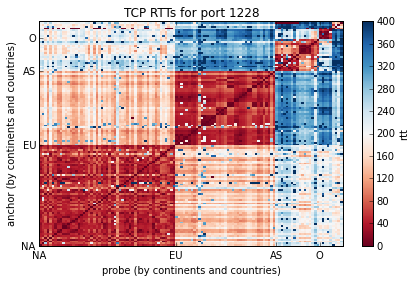

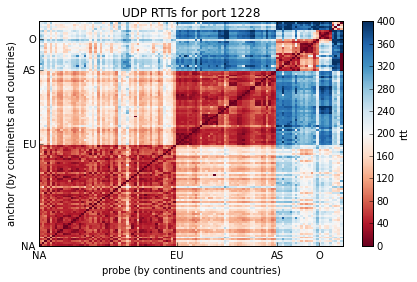

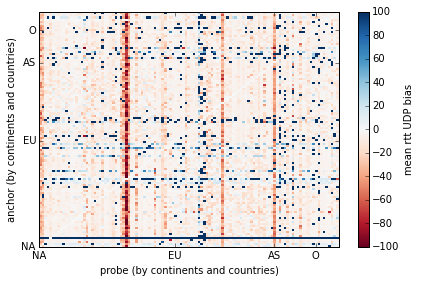

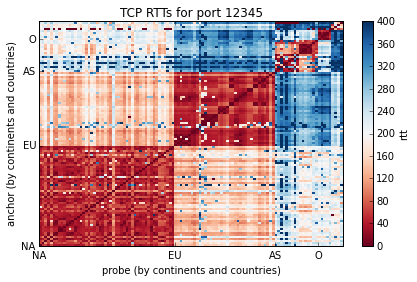

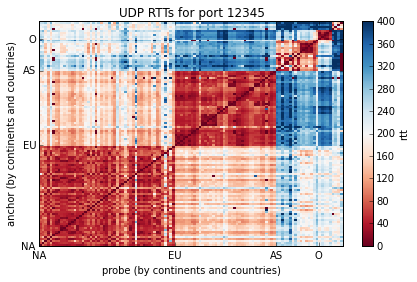

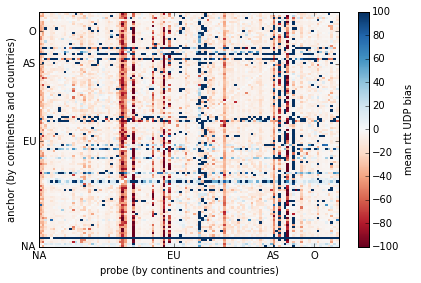

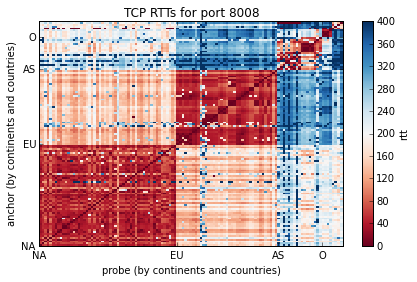

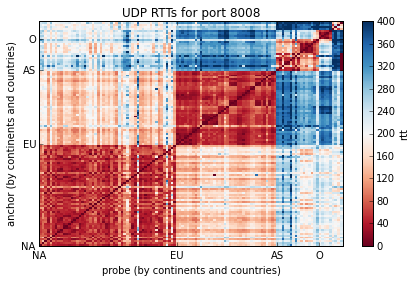

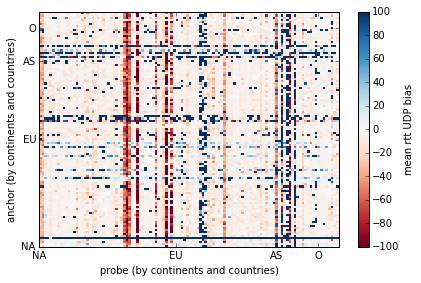

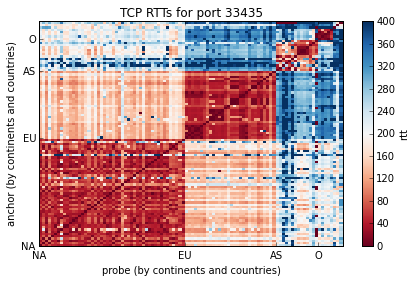

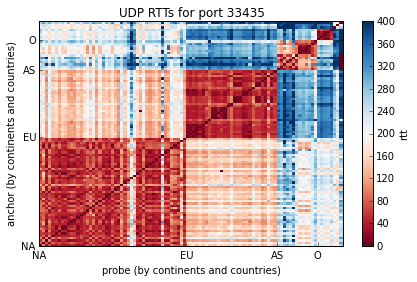

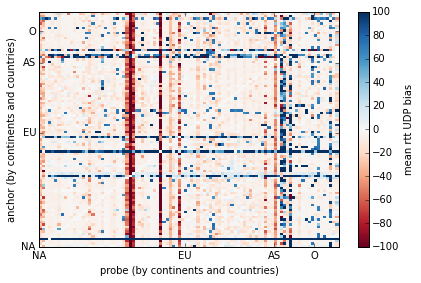

In [87]:
# Look at mean RTT per 3-tuples (saddr, daddr, dport)

agg(np.mean, "mean", legend2="mean rtt UDP bias")

tcp nodes: 118 udp nodes:115
118
tcp nodes: 112 udp nodes:114
112
tcp nodes: 117 udp nodes:115
117
tcp nodes: 100 udp nodes:97
100


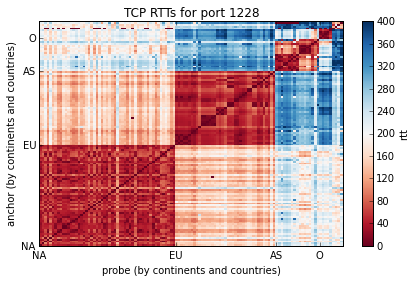

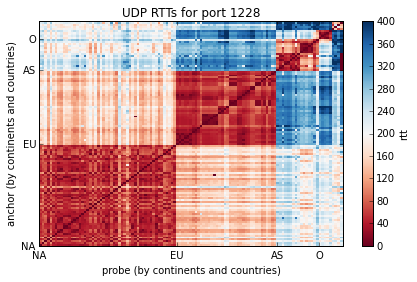

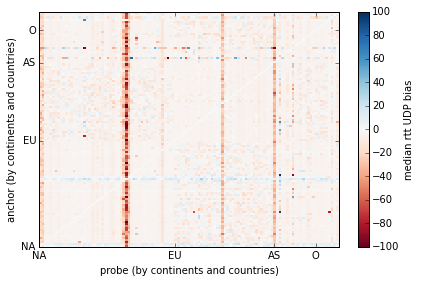

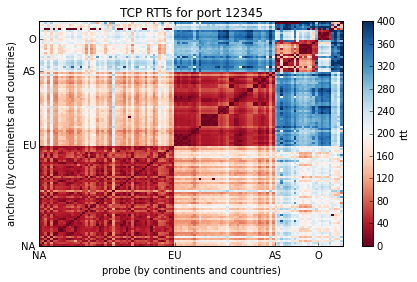

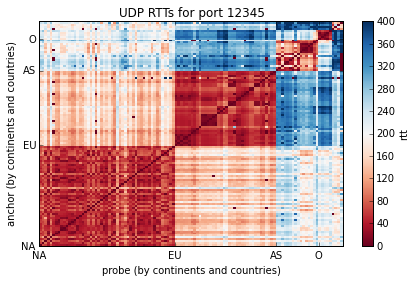

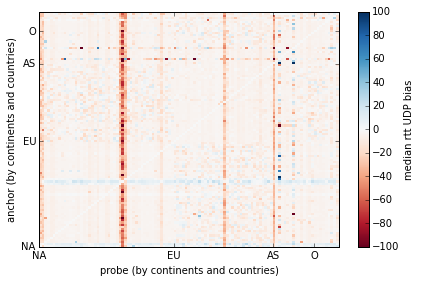

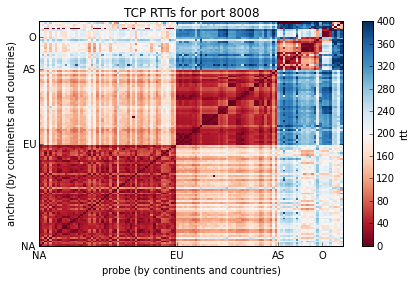

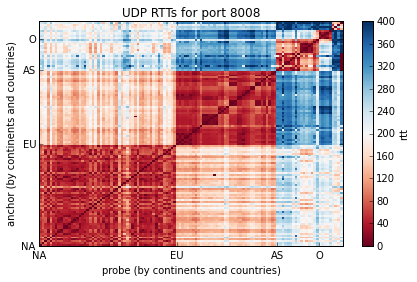

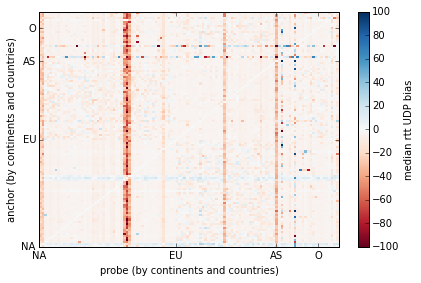

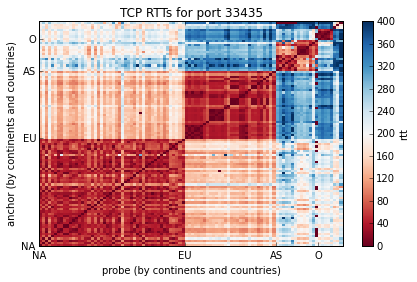

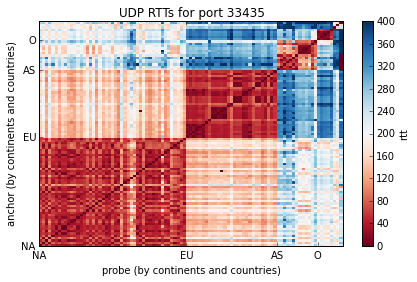

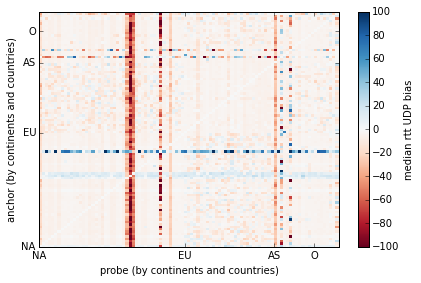

In [81]:
# median 

agg(np.median, "median", legend2="median rtt UDP bias", save=True)

tcp nodes: 118 udp nodes:115
118
tcp nodes: 112 udp nodes:114
112
tcp nodes: 117 udp nodes:115
117
tcp nodes: 100 udp nodes:97
100


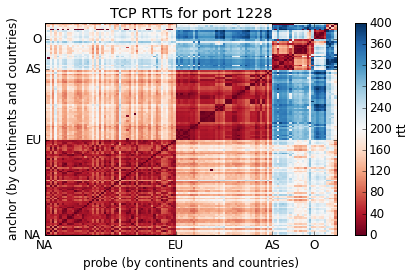

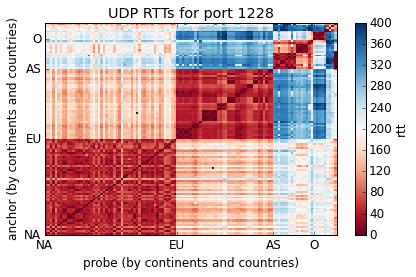

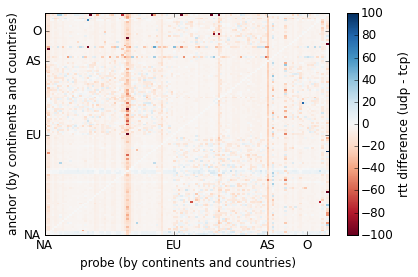

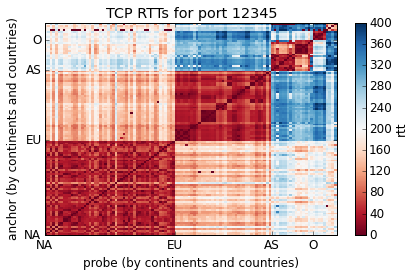

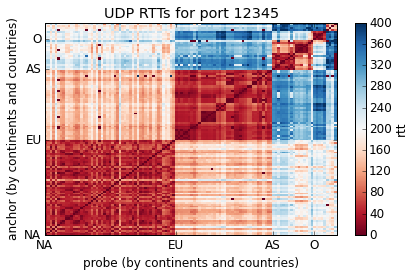

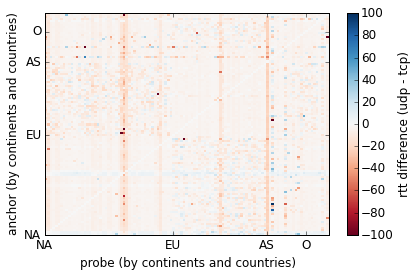

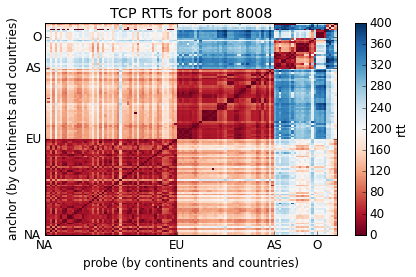

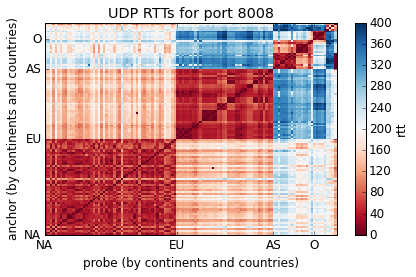

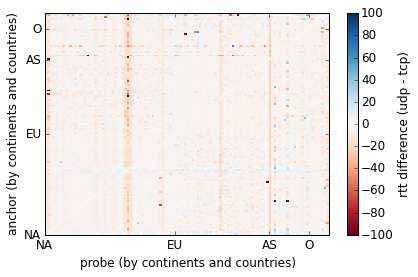

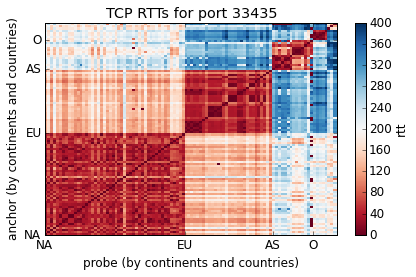

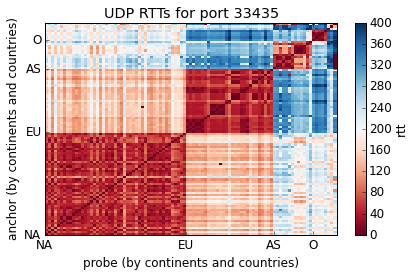

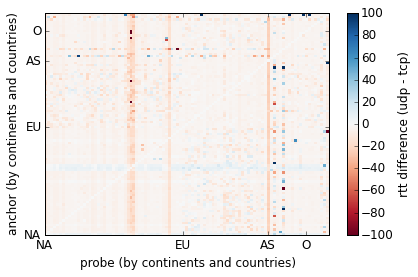

In [116]:
# Look at min RTT per 3-tuples (saddr, daddr, dport)

agg(np.min, "amin")

tcp nodes: 118 udp nodes:115
118
tcp nodes: 112 udp nodes:114
112
tcp nodes: 117 udp nodes:115
117
tcp nodes: 100 udp nodes:97
100


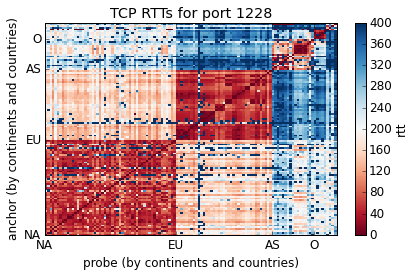

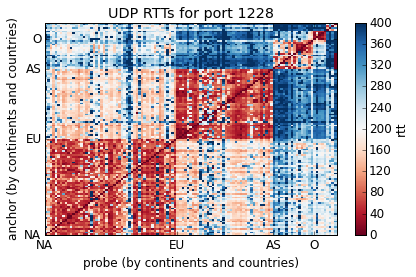

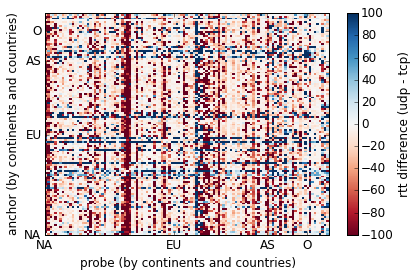

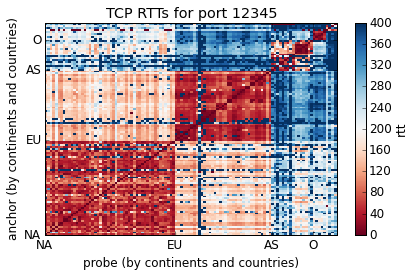

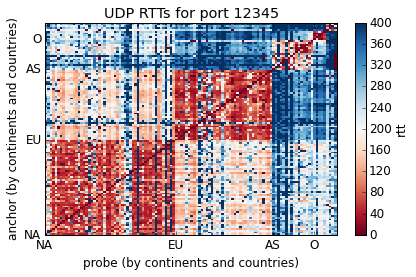

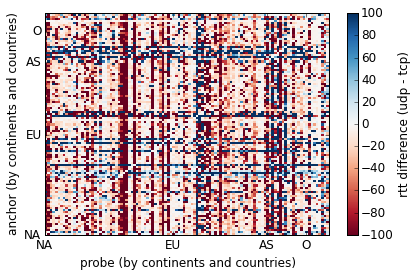

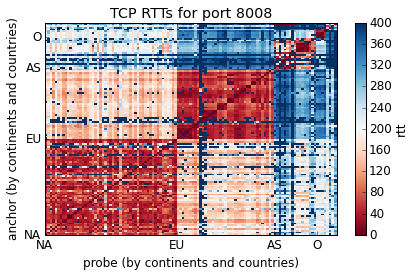

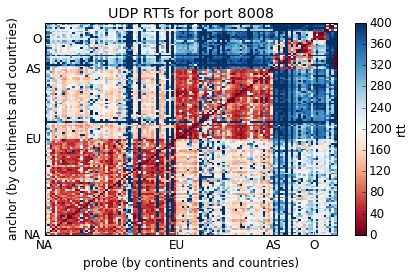

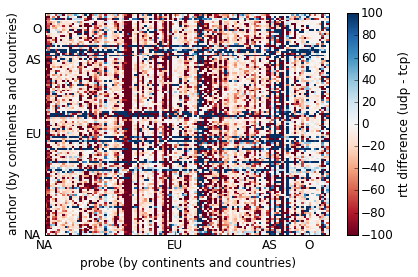

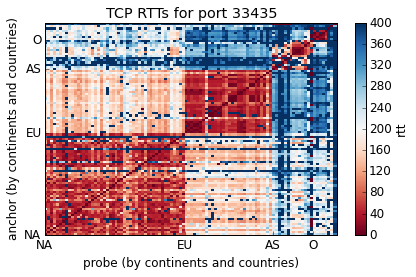

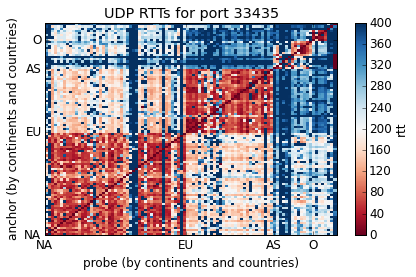

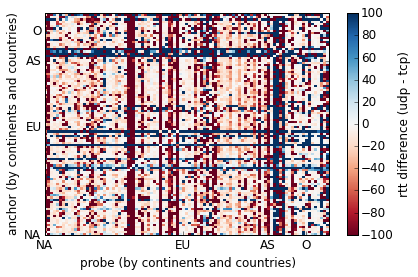

In [117]:
agg(np.max, "amax")

tcp nodes: 118 udp nodes:115
118
tcp nodes: 112 udp nodes:114
112
tcp nodes: 117 udp nodes:115
117
tcp nodes: 100 udp nodes:97
100


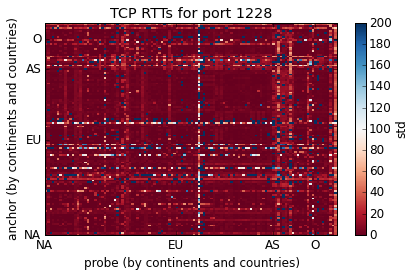

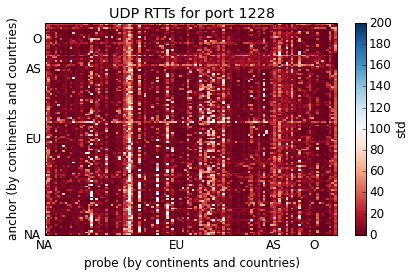

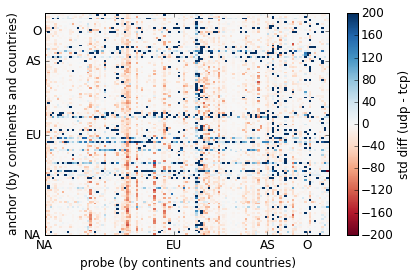

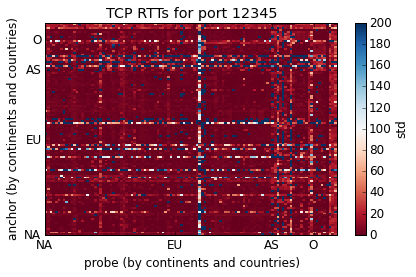

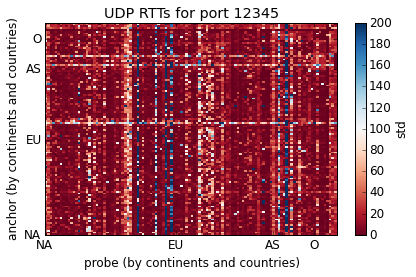

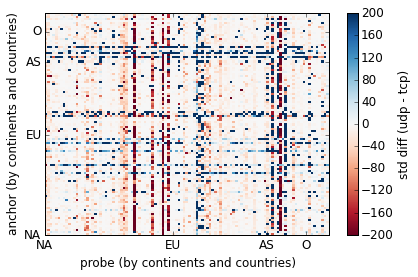

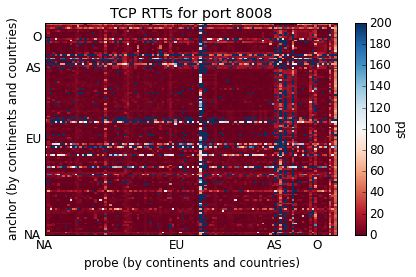

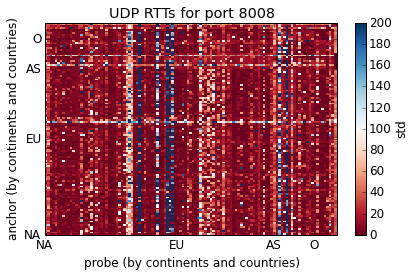

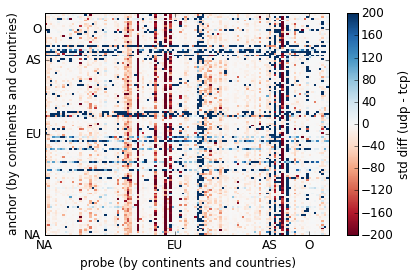

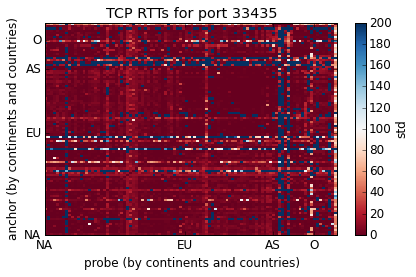

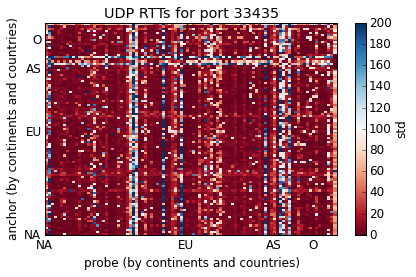

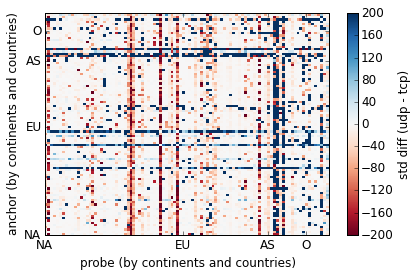

In [118]:
maxval = 200
agg(np.std, "std", vrange1=[0,maxval], vrange2=[-maxval,maxval], legend1="std", legend2="std diff (udp - tcp)")

tcp nodes: 118 udp nodes:115
118
tcp nodes: 112 udp nodes:114
112
tcp nodes: 117 udp nodes:115
117
tcp nodes: 100 udp nodes:97
100


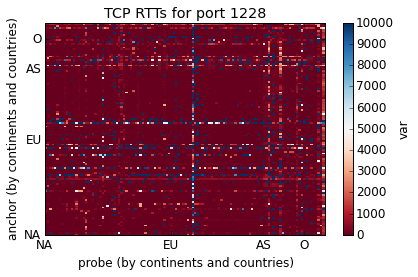

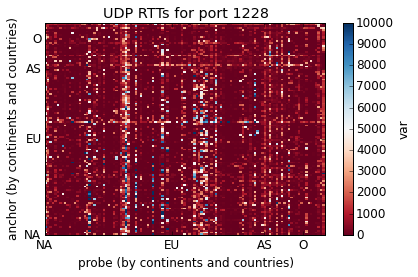

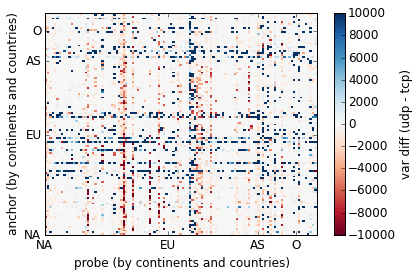

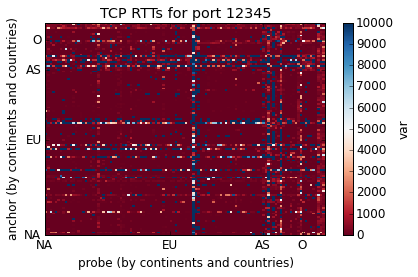

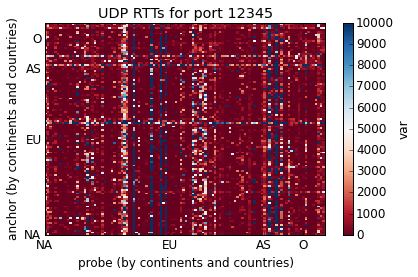

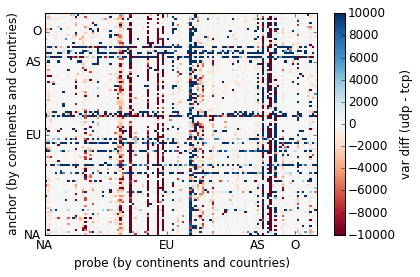

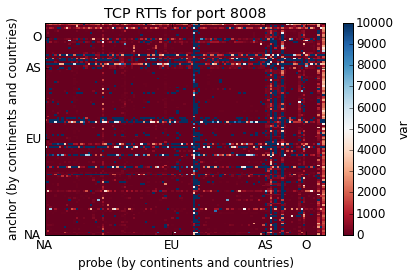

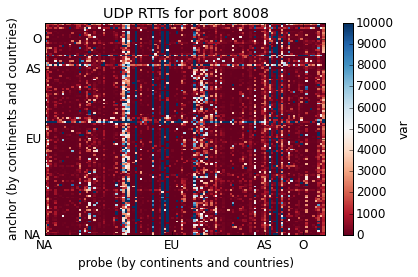

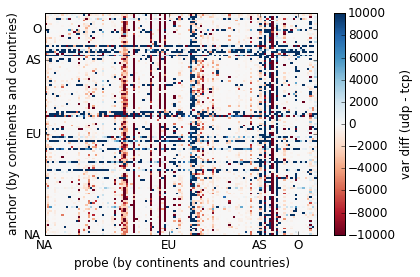

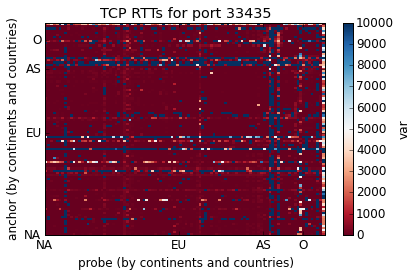

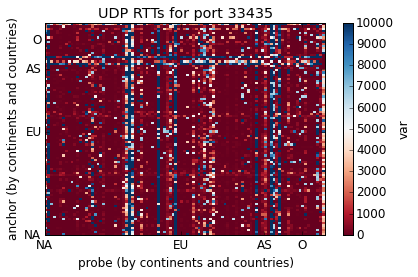

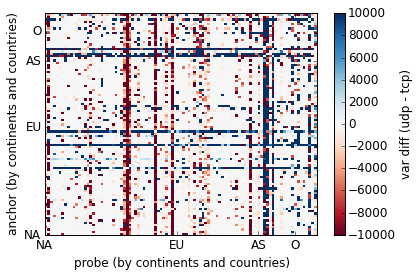

In [119]:
# variance
maxval = 10000
agg(np.var, "var", vrange1=[0,maxval], vrange2=[-maxval,maxval], legend1="var", legend2="var diff (udp - tcp)")

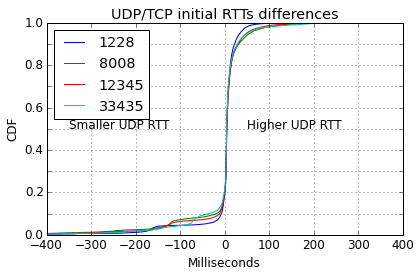

In [120]:
# Averaged by 3-tuple (saddr,daddr,dport)
import graph
imp.reload(graph)
# plot CDFs
tcp_df  = tcp.reset_index()
udpc_df = udpc.reset_index()

# Average RTTs
avg_index = ["sourceIPv4Address", "destinationIPv4Address", "destinationTransportPort"]
grouped_tcp  = tcp_df.groupby(avg_index)["reverseFlowDeltaMilliseconds"]
grouped_udpc = udpc_df.groupby(avg_index)["reverseFlowDeltaMilliseconds"]
tcp_df  = grouped_tcp.agg([np.mean])
udpc_df = grouped_udpc.agg([np.mean])

# compute rtt difference per 3-tuples
clip_at = 400
diff    = (udpc_df - tcp_df).dropna().clip(-clip_at,clip_at).reset_index()

# plot rtt difference per dport
this_port = []
for port in [1228, 8008, 12345, 33435]:
    this_port.append(diff[diff.destinationTransportPort == port]["mean"])
    
# "plots/rtt-diff.pdf"
_=graph.cdf(this_port, "UDP/TCP initial RTTs differences", "Milliseconds", "CDF", 
    None, num=10000,
    labels=["1228", "8008", "12345", "33435"],xlim=[-clip_at,clip_at],
    ann=[("Smaller UDP RTT",(-(clip_at*0.875),.5)),("Higher UDP RTT",((clip_at*0.125),.5))], font_size=12,
    xticks=np.arange(-clip_at,clip_at+1,100),
    yticks=np.arange(0,101,10)/100, 
    ytickslabel=[str(e/100) if (e%20==0) else "" for e in range(0,101,10)])


In [91]:
# plot CDFs of raw RTTs value (no meaning involved)
tcp_df  = tcp#.reset_index()
udpc_df = udpc#.reset_index()

# compute RTT diffs 
raw_index = ["sourceIPv4Address", "destinationIPv4Address", 
             "destinationTransportPort", "copycatRunId", "copycatFileSize"]
raw_diff  = (udpc_df.set_index(raw_index)["reverseFlowDeltaMilliseconds"] 
             - tcp_df.set_index(raw_index)["reverseFlowDeltaMilliseconds"]).dropna()

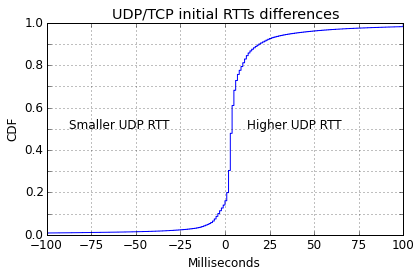

In [92]:
# plot CDFs of raw RTTs value (no meaning involved)
import graph
imp.reload(graph)

# clip outliers
clip_at = 100
this_diff = raw_diff.clip(-clip_at, clip_at)

# "plots/rtt-raw.pdf"
_ = graph.cdf(this_diff, "UDP/TCP initial RTTs differences", "Milliseconds", "CDF", 
          None, num=100000,
          ann=[("Smaller UDP RTT",(-87.5,.5)),("Higher UDP RTT",(12.5,.5))], font_size=12,
          xticks=np.arange(-clip_at,clip_at+1,25),
          yticks=np.arange(0,101,10)/100, 
          ytickslabel=[str(e/100) if (e%20==0) else "" for e in range(0,101,10)])

In [100]:
raw_index = ["sourceIPv4Address", "destinationIPv4Address", 
             "destinationTransportPort", "copycatRunId", "copycatFileSize",
            "copycatCampaignId"]
tcp  = tcp.set_index(raw_index)
udpc = udpc.set_index(raw_index)

In [101]:
#rtts to csv
d1=udpc.rename(columns={"reverseFlowDeltaMilliseconds":"udpRtt"})
d2=tcp.rename(columns={"reverseFlowDeltaMilliseconds":"tcpRtt"})
joined = d1.join(d2, how='inner').dropna()
joined.reset_index()[["udpRtt", "tcpRtt"]].to_csv("copycat-rtts.csv")

/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


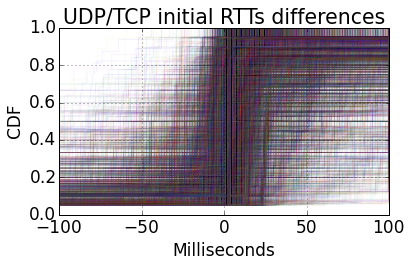

In [55]:
imp.reload(graph)
# plot one CDF per path
ind = ["sourceIPv4Address", "destinationIPv4Address"]
ies = ind + ["reverseFlowDeltaMilliseconds"]
dists = raw_diff.reset_index()[ies]
dists = dists.groupby(ind)["reverseFlowDeltaMilliseconds"].apply(lambda x: x.tolist())

clip_at = 200
_=graph.cdf(list(dists), "UDP/TCP initial RTTs differences", "Milliseconds", "CDF", None, num=1000,alpha=0.05)

/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


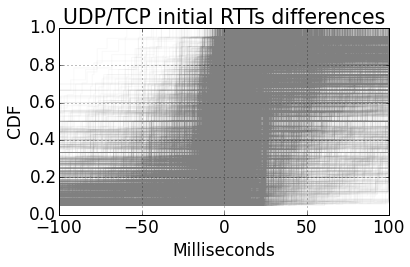

In [58]:
imp.reload(graph)
# plot one CDF per path
ind = ["sourceIPv4Address", "destinationIPv4Address"]
ies = ind + ["reverseFlowDeltaMilliseconds"]
dists = raw_diff.reset_index()[ies]
dists = dists.groupby(ind)["reverseFlowDeltaMilliseconds"].apply(lambda x: x.tolist())

clip_at = 200
_=graph.cdf(list(dists), "UDP/TCP initial RTTs differences", 
            "Milliseconds", "CDF", None, 
            num=1000,alpha=0.05,color="grey")

(-500, 500)

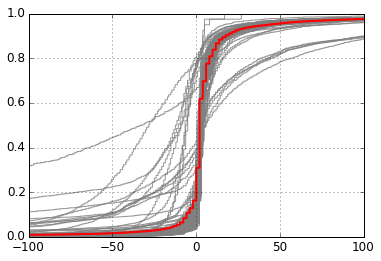

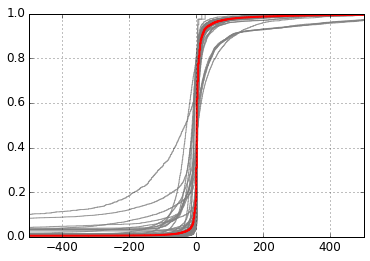

In [90]:
# plot per-dest distri
import pylab as p

imp.reload(graph)
ind = ["destinationIPv4Address"]
ies = ind + ["reverseFlowDeltaMilliseconds"]
dists = raw_diff.reset_index()[ies]
dists = dists.groupby(ind)["reverseFlowDeltaMilliseconds"].apply(lambda x: x.tolist())

clip_at = 100
p.figure()
p.grid()
for i,d in enumerate(list(dists)):
    x, y = graph.format_cdf(d)
    p.step(x, y, alpha=0.8, color="grey")
x, y = graph.format_cdf(raw_diff)  
p.step(x, y, linewidth=2, color="r")
p.xlim(-clip_at,clip_at)

clip_at = 500
p.figure()
p.grid()
for i,d in enumerate(list(dists)):
    x, y = graph.format_cdf(d)
    p.step(x, y, alpha=0.8, color="grey")
x, y = graph.format_cdf(raw_diff)  
p.step(x, y, linewidth=2, color="r")
p.xlim(-clip_at,clip_at)

(-500, 500)

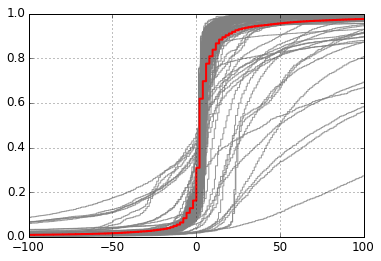

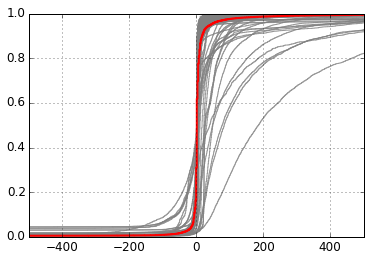

In [91]:
# plot per-dest distri
import pylab as p

imp.reload(graph)
ind = ["sourceIPv4Address"]
ies = ind + ["reverseFlowDeltaMilliseconds"]
dists = raw_diff.reset_index()[ies]
dists = dists.groupby(ind)["reverseFlowDeltaMilliseconds"].apply(lambda x: x.tolist())

clip_at = 100
p.figure()
p.grid()
for i,d in enumerate(list(dists)):
    x, y = graph.format_cdf(d)
    p.step(x, y, alpha=0.8, color="grey")
x, y = graph.format_cdf(raw_diff)  
p.step(x, y, linewidth=2, color="r")
p.xlim(-clip_at,clip_at)

clip_at = 500
p.figure()
p.grid()
for i,d in enumerate(list(dists)):
    x, y = graph.format_cdf(d)
    p.step(x, y, alpha=0.8, color="grey")
x, y = graph.format_cdf(raw_diff)  
p.step(x, y, linewidth=2, color="r")
p.xlim(-clip_at,clip_at)